# Машинное обучение, ФКН ВШЭ

# Практическое задание 13. Рекомендательные системы

## Общая информация
**Дата выдачи: 20.05.2023**

**Мягкий дедлайн: 03.06.2023 23:59 MSK**

**Жёсткий дедлайн: 08.06.2023 23:59 MSK**

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — **11** баллов + **2.5** бонусных.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-13-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

## О задании

В этой работе мы будем решать задачу рекомендации музыки. То есть мы поставим целью получить модель, которая для каждого пользователя будет возвращать набор треков, наиболее похожих на те, что он уже слушал. В первой части мы разберемся с memory-based подходом и моделью со скрытыми переменными. Это не очень мощные методы, но зато они позволяют строить предсказания почти моментально. Затем, во второй части, мы обратим внимание на то, что датасет содержит огромное число треков и воспользуемся результатами уже построенных быстрых моделей для сокращения списка кандидатов до разумного количества. После этого проведем ранжирование среди кандидатов с помощью сильной, но чуть более медленной модели, и отберем самые лучшие варианты. Такой двухэтапный алгоритм построения рекомендаций изображен на картинке.


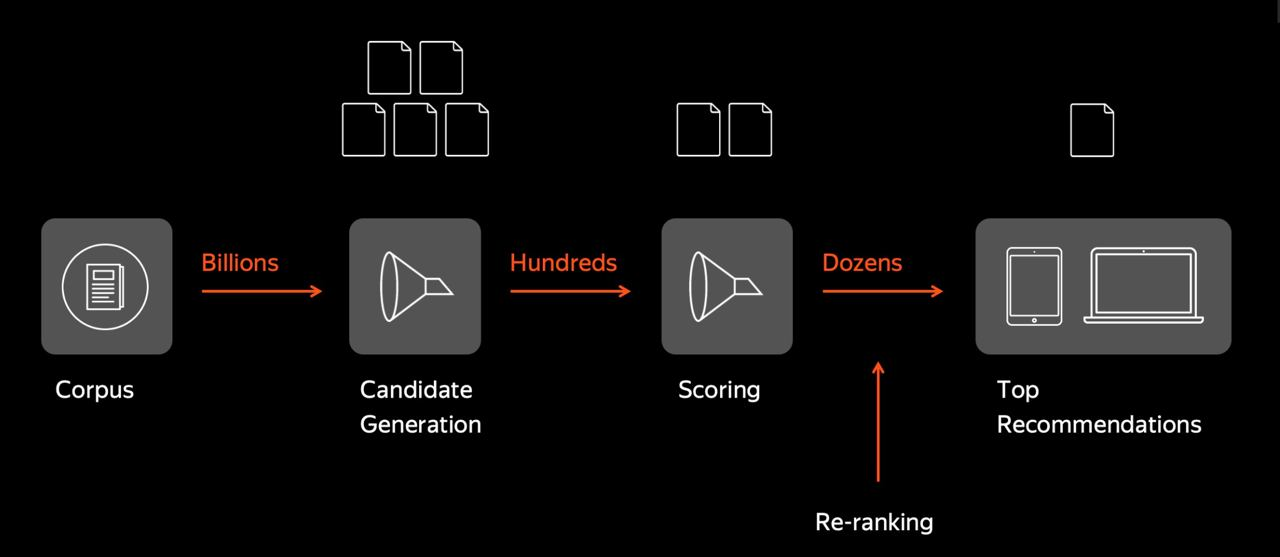

Приступим!

Все шаблоны ниже можно переписывать по своему усмотрению.

In [2]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

In [3]:
ratings = pd.read_csv('music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [4]:
tracks_info = pd.read_csv('tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (0.5 балл).** Реализуйте метрику $MAP@k$.

In [5]:
def ru(relevant, predicted, i):
    return np.isin(predicted[:i], relevant)

def precision(relevant, predicted, k):
    s = np.cumsum(ru(relevant, predicted, k))
    return s / np.arange(1, k + 1)

def apk(relevant, predicted, k):
    # relevant, predicted for user u
    s = (ru(relevant, predicted, k) * precision(relevant, predicted, k)).sum()
    return s / min(k, len(relevant))

def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):
    s = 0
    for u in range(len(relevant)):
        s += apk(relevant[u], predicted[u], k)
    return s / len(relevant)

In [6]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

assert round(mapk(relevant, pred, k=5), 4) == 0.4331

In [7]:
ratings

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404
...,...,...
141449,240,69609
141450,240,69843
141451,240,70180
141452,240,70233


Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [8]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [9]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [10]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [11]:
tracks_info

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']
...,...,...,...
67308,71778,Син Икэн Ул,"['Зинира Рамазанова', 'Ризат Рамазанов']"
67309,71793,Лифон,"['Uniqe', 'nkeeei', 'ARTEM SHILOVETS', 'SAGARA']"
67310,71798,Снегом стать,['Жин-Жин']
67311,71813,Башня,"['Даня Милохин', 'Мумий Тролль']"


In [12]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [13]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [14]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [15]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


In [16]:
test_ratings

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168
...,...,...
6128,240,65864
6129,240,65953
6130,240,66287
6131,240,66348


Соберем все релевантные треки для каждого пользователя в список.

In [17]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

In [18]:
test_ratings

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168
...,...,...
6128,240,65864
6129,240,65953
6130,240,66287
6131,240,66348


**Задание 2 (0.5 балла).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [19]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.0
        
    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []
        # (￣▽￣)/♫•*¨*•.¸¸♪
        for u in range(self.n_users):
            test_preds += [self.recommend(u)]
        test_preds = self.remove_train_items(test_preds, k)
        return test_preds[test_users]

### Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать меру Жаккара:

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Во всех формулах 
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.2 (0.5 балла).** Реализуйте функцию подсчета меры Жаккара.

Функция принимает матрицу оценок и вектор оценок пользователя $u$ и возвращает вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

In [20]:
def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
    intersection = (ratings * user_vector).sum(1)
    unity = (user_vector.sum() + ratings.sum(1)) - intersection
    return intersection / unity

**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок. Значение парамметра `alpha` можно менять по своему усмотрению так, чтобы оно было разумным.

In [21]:
class User2User(BaseModel):
    def __init__(self, ratings):
        super().__init__(ratings)

        self.similarity_func = jaccard
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        return self.similarity_func(self.R, user_vector=user_vector)

    def recommend(self, uid: int):
        s = self.similarity(self.R[uid])
        neighs_idx = np.where(s > self.alpha)[0]
        neighs_idx = neighs_idx[neighs_idx != uid]
        return np.argsort(-1 * (s[neighs_idx] @ self.R[neighs_idx]))

**Задание 5 (0.5 балл).** Постройте график зависимости значений $MAP@k$ от разных $k$ при рекомендации на основе меры Жаккара, сравните его с рекомендициями самых популярных треков и случайных. Какой из трех способов рекомендаций оказался лучшим?

In [23]:
collab_filtration = User2User(train_ratings)

k = 50
collab_user2user = collab_filtration.get_test_recommendations(k)
random = np.random.choice(np.unique(ratings['trackId']), size=(len(test_users), k))
popular = np.array([np.argsort(-1 * collab_filtration.R.sum(0))[:k] for u in test_users])

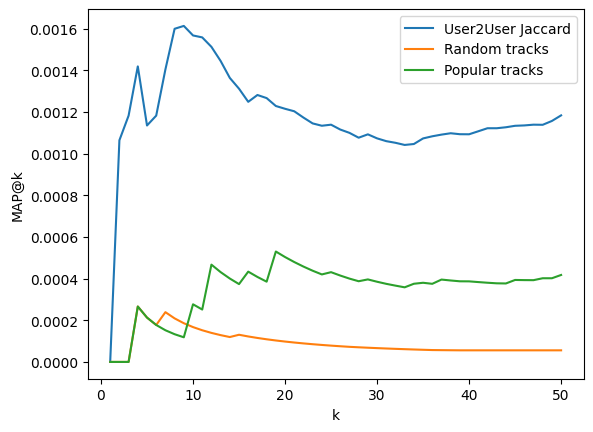

In [24]:
plt.plot(np.arange(1, k + 1), list(mapk(test_relevant, collab_user2user, k) for k in np.arange(1, k + 1)), label='User2User Jaccard')
plt.plot(np.arange(1, k + 1), list(mapk(test_relevant, random, k) for k in np.arange(1, k + 1)), label='Random tracks')
plt.plot(np.arange(1, k + 1), list(mapk(test_relevant, popular, k) for k in np.arange(1, k + 1)), label='Popular tracks')
plt.xlabel('k')
plt.ylabel('MAP@k')
plt.legend()
plt.show()

Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [25]:
user_id = np.random.randint(0, collab_filtration.n_users)

In [26]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
316,Pain,['Jimmy Eat World']
581,Gimme! Gimme! Gimme! (A Man After Midnight),['ABBA']
1552,Savior,['Rise Against']
1714,Losing You,['Dead by April']
2443,Falling Inside the Black,['Skillet']
2832,The Sharpest Lives,['My Chemical Romance']
3907,Breathing,['Yellowcard']
4036,Going Under,['Evanescence']
4038,Whisper,['Evanescence']
4730,Brand New Day,['Ryan Star']


In [27]:
preds = collab_filtration.get_test_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

Predicted tracks:


,name,artists
24500,Way Down We Go,['KALEO']
59229,Мальчик на девятке,['DEAD BLONDE']
24731,The Hills,['The Weeknd']
18459,Take Me To Church,['Hozier']
63838,Cristal & МОЁТ,['MORGENSHTERN']
15272,Sweater Weather,['The Neighbourhood']
12037,Summertime Sadness,['Lana Del Rey']
53135,3x3,"['Gruppa Skryptonite', '104', 'T-Fest']"
25287,М.Л.Д.,['ЛСП']
49577,Кукла колдуна,['Король и Шут']


In [28]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
64605,Controlla,['Yarimov']
64743,Dernière Danse,"['Yves V', 'Shanguy', 'Axel Cooper']"
65096,In the End Remix,"['Rock', 'Lo Mejor']"
65251,Ещё горит,['LASCALA']
65290,Royalty,"['Neoni', 'Egzod', 'Maestro Chives']"
65344,Rampampam,"['Minelli', 'Robert Cristian']"
65479,Astronaut In The Ocean,"['Masked Wolf', 'Alok']"
65579,Memories,"['Coopex', 'New Beat Order', 'Nito-Onna']"
65670,Calabria,"['Strange Fruits Music', 'DMNDS', 'Lunis', 'Fa..."
65690,The Usual,"['Shannon Jae Prior', 'Jesse Scott']"


Не очень хорошо, но есть похожие треки и исполнители

### Часть 2. Модель со скрытыми переменными: ALS

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно. 

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

__P. S.__ Заметьте, что описанная модель предназначена для работы только с __явной__ информацией. В нашем случае от модели будет требоваться всегда возвращать 1, так как мы считаем ошибку только по парам, о которых получили фидбек. Поэтому логично подумать, что постановка задачи не имеет смысла. Однако, на практике оказывается, что из-за случайности в инициализации матриц $P$ и $Q$, обученные векторы для всех треков и пользователей в конце обучения получаются разными. Поэтому модель все же не лишена смысла.

__P. P. S.__ Для более разумной работы с неявной информацией был предложен метод iALS, его описание можно найти в лекции. Ниже будет бонус на его реализацию.

**Задание 6 (0.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Выведите формулы обновления параметров для обоих методов.

**SGD:**

$\nabla_{p_u} L = 2\sum_{i} (p_u^T q_i - r_{ui}) \cdot q_i + 2\lambda p_u$ 

$\nabla_{q_u} L = 2\sum_{i} (q_i^T p_u - r_{ui}) \cdot p_u + 2\lambda q_i$ 

Тогда шаг для $r_{ui}$ имеет вид:

$p_u = p_u - \eta \; ((p_u^Tq_i - r_{ui}) \cdot q_i + \lambda p_u) $ 

$q_i = q_i - \eta \; ((q_i^Tp_u - r_{ui}) \cdot p_u + \lambda q_i) $

где $\eta$ - темп обучения


**ALS:**

$L = ||(R - P^TQ)||_F^2 + \lambda(||P||_F^2 + ||Q||_F^2)$

Дифференциал по $P$:

$d_P [L] = d[tr((R - P^TQ)^T(R - P^TQ))] + d[\lambda tr(P^TP)] = 2 \cdot tr((R - P^T Q)^T(-d[P^T] Q])) + 2 \cdot tr(\lambda P^T d[P]) = tr(2((P^TQ - R)Q^T + \lambda P^T)d[P])$

Отсюда получаем градиент:

$\nabla_{P} L = 2 \cdot (Q(P^TQ - R)^T + \lambda P)$ 

Приравниваем к нулю и выводим аналитическую формулу для оптимального P:

$2(Q(P^TQ - R)^T + \lambda P) = 0$ 

$P = (\lambda I + QQ^T)^{-1}QR^T$ 

Оптимальная Q выводится аналогично:

$Q = (\lambda I + PP^T)^{-1}PR$

$P$ и $Q$ транспонируем, чтобы вычисления занимали меньше памяти

**Задание 7 (1.5 балла).** Реализуйте методы оптимизации параметров для обоих алгоритмов.

In [22]:
class LatentFactorModel(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd'):
        super().__init__(ratings)
        self.dim = dim
        
        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))

        self.lr = 0.0003
        self.lamb = 0.01

    def fit(self, num_iters=5):
        for epoch in tqdm(range(num_iters)):
            if self.mode == 'sgd':
                items_idx, users_idx = np.random.randint(low=0, high=self.n_items), np.random.randint(low=0, high=self.n_users)
                q, p = self.Q[items_idx, :], self.P[users_idx, :]
                pq = p @ q
                self.Q[items_idx, :] = q - self.lr * ((pq - self.R[users_idx][items_idx]) * p + q * self.lamb)
                self.P[users_idx, :] = p - self.lr * ((pq - self.R[users_idx][items_idx]) * q + p * self.lamb)

            elif self.mode == 'als':
                self.P = (np.linalg.inv(self.Q.T @ self.Q + self.lamb * np.eye(self.dim)) @ self.Q.T @ self.R.T).T
                self.Q = (np.linalg.inv(self.P.T @ self.P + self.lamb * np.eye(self.dim)) @ self.P.T @ self.R).T
                

    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T

        return np.argsort(pred_rating)[::-1]

**Задание 8 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

__P. S.__ Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

__P. P. S.__ Методу SGD свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

In [31]:
dim_grid = np.arange(32, 257, 32)
k_grid = np.arange(1, 51)
num_iters_grid = np.arange(5, 306, 20)

gs_res = {}

In [ ]:
for opt_method in ['sgd']:
    gs_res[opt_method] = [] # for each num iter
    for num_iters in tqdm(num_iters_grid):
        gs_res[opt_method].append({'map': 0})
        for dim in tqdm(dim_grid):
            lfm = LatentFactorModel(train_ratings, dim, opt_method)
            lfm.fit(num_iters)
            predictions = lfm.get_test_recommendations(50)
            for k in k_grid:
                map = mapk(test_relevant, predictions, k)
                if map > gs_res[opt_method][-1]['map']:
                    gs_res[opt_method][-1] = {
                        'map': map,
                        'k': k,
                        'dim': dim
                    }

In [ ]:
for opt_method in ['als']:
    gs_res[opt_method] = [] # for each num iter
    for num_iters in tqdm(num_iters_grid):
        gs_res[opt_method].append({'map': 0})
        for dim in tqdm(dim_grid):
            lfm = LatentFactorModel(train_ratings, dim, opt_method)
            lfm.fit(num_iters)
            predictions = lfm.get_test_recommendations(50)
            for k in k_grid:
                map = mapk(test_relevant, predictions, k)
                if map > gs_res[opt_method][-1]['map']:
                    gs_res[opt_method][-1] = {
                        'map': map,
                        'k': k,
                        'dim': dim
                    }

In [51]:
sgd_df = pd.DataFrame(gs_res['sgd'])
sgd_df

,map,k,dim
0,0.000266,4,256
1,0.000266,4,64
2,0.004255,1,64
3,0.004255,1,256
4,0.004255,1,64
5,0.001064,2,96
6,0.001064,2,256
7,0.008511,1,192
8,0.004255,1,64
9,0.001064,2,32


In [53]:
als_df = pd.DataFrame(gs_res['als'])
als_df

,map,k,dim
0,0.005319,2,128
1,0.008511,1,96
2,0.004255,1,64
3,0.004255,1,64
4,0.008511,1,96
5,0.004255,1,64
6,0.004255,1,64
7,0.008511,1,256
8,0.008511,1,96
9,0.005319,2,96


In [57]:
print('best sgd:')
print(sgd_df.iloc[sgd_df['map'].idxmax()])
print()
print('best als:')
print(als_df.iloc[als_df['map'].idxmax()])

best sgd:
map      0.008511
k        1.000000
dim    192.000000
Name: 7, dtype: float64

best als:
map     0.008511
k       1.000000
dim    96.000000
Name: 1, dtype: float64


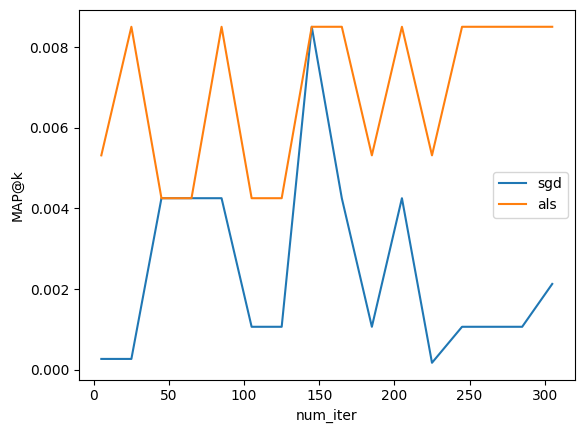

In [55]:
plt.plot(num_iters_grid, [info['map'] for info in gs_res['sgd']], label='sgd')
plt.plot(num_iters_grid, [info['map'] for info in gs_res['als']], label='als')
plt.xlabel('num_iter')
plt.ylabel('MAP@k')
plt.legend()
plt.show()

Оба метода показали одинаковый наилучший результат, но als в среднем давал более высокий MAP, поэтому он лучше подходит. По сравнению с user2user MAP стала выше почти в 8 раз и гораздо лучше случайного подхода.

Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [27]:
model = LatentFactorModel(train_ratings, 96, 'als')
model.fit(25)

  0%|          | 0/25 [00:00<?, ?it/s]

In [30]:
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = model.Q @ model.Q[example_trackId]
preds = preds / np.sqrt((model.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [31]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(model.Q[example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
2058,Последний герой,['КИНО'],0.682585
73,The Greatest,['Cat Power'],0.643190
10282,Владивосток 2000,['Мумий Тролль'],0.642971
2909,She's Lost Control,['Joy Division'],0.637912
13264,Безобразная Эльза,['Крематорий'],0.623397
13263,Мусорный ветер,['Крематорий'],0.623397
25952,Венгерский танец No. 5,"['Альгис Жюрайтис', 'Оркестр Большого театра',...",0.620220
17794,Несуразная,['АлоэВера'],0.615917
16295,Push the Sky Away,['Nick Cave & The Bad Seeds'],0.615917


Ну вроде треки похожи реально

### Часть 3. Второй уровень рекомендаций.

Выше мы построили простейшие модели, которые показывают не слишком высокое качество, но зато работают очень быстро. Воспользуемся ими для того, чтобы отобрать некоторое количество наиболее перспективных треков, которые мы сможем отранжировать уже более сложной моделью (в нашем случае это будет [CatBoost](https://catboost.ai/en/docs/concepts/python-reference_catboost)).

**Задание 9 (1 балл).**

Для каждого пользователя возьмите топ-100 рекомендованных треков от модели LFM (ALS или SGD на ваш выбор) и топ-100 от модели User2User. Это будут наши кандидаты, которые мы затем будем ранжировать бустингом.

In [32]:
lfm = LatentFactorModel(train_ratings, 96, 'als')
lfm.fit(25)
lfm_predictions = lfm.get_test_recommendations(100)

  0%|          | 0/25 [00:00<?, ?it/s]

In [33]:
u2u = User2User(train_ratings)
u2u_predictions = u2u.get_test_recommendations(100)

In [34]:
lfm_predictions.shape, u2u_predictions.shape

((235, 100), (235, 100))

**Задание 10 (2 балла).**

Подготовьте датасет для обучения модели ранжирования. Он должен состоять из пар: объект, целевая переменная. Объект - это пара (user, item) и всякие дополнительные признаки на их основе. Предлагается создать набор следущих признаков, однако вы можете добавлять свои по желанию, если они вам кажутся разумными:
 1) id пользователя
 1) id трека
 1) косинусное расстояние между эмбеддингами LFM соответствующих пользователя и трека
 1) среднее значение меры Жаккара между этим пользователем и остальными из User2User модели
 1) доля пользователей, слушавших этот трек (взять из обучающей выборки в Части 1)
 1) количество прослушанных пользователем треков (взять из обучающей выборки в Части 1)

В качестве целевой переменной возьмем бинарную метку "попал ли трек в 50 последних прослушанных пользователем"

Разбейте полученную выборку на обучающую и тестовую в отношении 3:2 так, чтобы пропорции положительных и отрицательных примеров в обоих подвыборках были одинаковыми.

In [35]:
train_objects = train_ratings.copy()

In [36]:
train_objects['cos_dist'] = (lfm.P[train_objects['userId']] * lfm.Q[train_objects['trackId']]).sum(1) / np.linalg.norm(lfm.P[train_objects['userId']], axis=1, ord=2) / np.linalg.norm(lfm.Q[train_objects['trackId']], axis=1, ord=2)

В реализации User2User jaccard функция не поддерживает матрицу, поэтому я переписал ниже, чтобы сразу предпосчет произвести

In [57]:
u2sim = [0] * 241

for u in train_objects['userId'].unique():
    u2sim[u] = (np.sum(u2u.similarity(u2u.R[u])) - 1) / 24
    

In [63]:
train_objects['mean_jaccard'] = np.array(u2sim)[train_objects['userId']]

In [108]:
listen_freqs = train_objects['trackId'].value_counts().reset_index().set_index('trackId') / len(train_objects['userId'].unique())
train_objects['listen_frac'] = listen_freqs.loc[train_objects['trackId']].reset_index()['count']

In [129]:
train_objects['tracks_listened'] = train_objects['userId'].value_counts()[train_objects['userId']].reset_index()['count']

In [153]:
last50tracks = []
for user_id, user_data in train_ratings.groupby('userId'):
    last50tracks.append(user_data['trackId'][:50])
last50tracks = np.array(last50tracks)

In [191]:
train_objects['y'] = train_objects.apply(lambda row: np.float32(row.trackId in last50tracks[int(row.userId)]), axis=1)

In [205]:
from sklearn.model_selection import train_test_split

features = ['userId', 'trackId', 'cos_dist', 'mean_jaccard', 'listen_frac',	'tracks_listened']

X_train, X_test, y_train, y_test = train_test_split(train_objects[features], train_objects['y'], test_size=2/5, random_state=42, stratify=train_objects['y'])

Как уже было сказано, для построения ранжирующей модели мы будем пользоваться библиотекой [CatBoost](https://www.youtube.com/watch?v=dQw4w9WgXcQ). 

Для преобразования датасета в удобный вид полезно использовать метод [`Pool`](https://catboost.ai/en/docs/concepts/python-reference_pool).

In [211]:
sort_idx = np.argsort(X_train['userId'])
X_train = X_train.iloc[sort_idx]
y_train = y_train.iloc[sort_idx]

sort_idx = np.argsort(X_test['userId'])
X_test = X_test.iloc[sort_idx]
y_test = y_test.iloc[sort_idx]

In [238]:
import catboost

# group_id == user_id here
train_pool = catboost.Pool(X_train, y_train, group_id=X_train['userId'])
test_pool = catboost.Pool(X_test, y_test, group_id=X_test['userId'])

**Задание 11 (1 балл)**

Обучите `CatBoostClassifier`. С его помощью сделайте предсказания для тестовой выборки и посчитайте MAP@20. Сравните с рекомендациями моделей User2User и LFM. Учтите, что для честного сравнения необходимо пересчитать предсказания моделей на нашей новой тестовой выборке. Получилось ли улучшить результаты?

In [261]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(iterations=1000)
model.fit(train_pool)

Learning rate set to 0.06607
0:	learn: 0.5565292	total: 17.1ms	remaining: 17.1s
1:	learn: 0.4598197	total: 30.8ms	remaining: 15.4s
2:	learn: 0.3898604	total: 39.5ms	remaining: 13.1s
3:	learn: 0.3363044	total: 48.9ms	remaining: 12.2s
4:	learn: 0.2863963	total: 62.7ms	remaining: 12.5s
5:	learn: 0.2540782	total: 71.8ms	remaining: 11.9s
6:	learn: 0.2309260	total: 81.7ms	remaining: 11.6s
7:	learn: 0.2119711	total: 89.8ms	remaining: 11.1s
8:	learn: 0.1977983	total: 98.4ms	remaining: 10.8s
9:	learn: 0.1864623	total: 107ms	remaining: 10.6s
10:	learn: 0.1772499	total: 117ms	remaining: 10.5s
11:	learn: 0.1690555	total: 127ms	remaining: 10.4s
12:	learn: 0.1631269	total: 138ms	remaining: 10.5s
13:	learn: 0.1591220	total: 149ms	remaining: 10.5s
14:	learn: 0.1549582	total: 159ms	remaining: 10.5s
15:	learn: 0.1513340	total: 168ms	remaining: 10.3s
16:	learn: 0.1481345	total: 176ms	remaining: 10.2s
17:	learn: 0.1448095	total: 185ms	remaining: 10.1s
18:	learn: 0.1417401	total: 193ms	remaining: 9.98s
19:

In [262]:
predictions = []

for u in X_test['userId'].unique():
    probas = model.predict_proba(X_test[X_test['userId'] == u])
    sort_idx = np.argsort(probas[:, 1])
    predictions.append(X_test.iloc[sort_idx]['trackId'].tolist())

In [282]:
test_relevant = []
test_users = []
for user_id, user_data in X_test.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

In [285]:
print('MAP@K for CatBoostClassifier:', mapk(test_relevant, predictions, 20))

MAP@K for CatBoostClassifier: 0.007522199971400607


Сильно больше не стало, даже меньше чем alf с подбором гиперпараметров

**Задание 12 (1 балл)**

Обучите `CatBoostRanker`, выбрав подходящую функцию ранжирования из тех, которые были рассмотрены на лекции. Проделайте все те же действия, что и с `CatBoostClassifier` и сравните результаты.

In [292]:
from catboost import CatBoostRanker

model = CatBoostRanker(iterations=50)
model.fit(train_pool)

0:	total: 132ms	remaining: 6.49s
1:	total: 264ms	remaining: 6.33s
2:	total: 458ms	remaining: 7.18s
3:	total: 686ms	remaining: 7.88s
4:	total: 847ms	remaining: 7.62s
5:	total: 1.01s	remaining: 7.39s
6:	total: 1.18s	remaining: 7.22s
7:	total: 1.35s	remaining: 7.08s
8:	total: 1.51s	remaining: 6.9s
9:	total: 1.66s	remaining: 6.65s
10:	total: 1.82s	remaining: 6.47s
11:	total: 1.99s	remaining: 6.29s
12:	total: 2.13s	remaining: 6.05s
13:	total: 2.31s	remaining: 5.94s
14:	total: 2.49s	remaining: 5.8s
15:	total: 2.65s	remaining: 5.64s
16:	total: 2.78s	remaining: 5.4s
17:	total: 2.91s	remaining: 5.18s
18:	total: 3.05s	remaining: 4.98s
19:	total: 3.21s	remaining: 4.82s
20:	total: 3.36s	remaining: 4.64s
21:	total: 3.52s	remaining: 4.49s
22:	total: 3.7s	remaining: 4.34s
23:	total: 3.85s	remaining: 4.17s
24:	total: 3.98s	remaining: 3.98s
25:	total: 4.13s	remaining: 3.81s
26:	total: 4.29s	remaining: 3.65s
27:	total: 4.46s	remaining: 3.5s
28:	total: 4.6s	remaining: 3.33s
29:	total: 4.76s	remaining: 3.

In [294]:
predictions = []

for u in X_test['userId'].unique():
    rankings = model.predict(X_test[X_test['userId'] == u])
    sort_idx = np.argsort(rankings)
    predictions.append(X_test.iloc[sort_idx]['trackId'].tolist())

In [295]:
print('MAP@K for CatBoostRanking:', mapk(test_relevant, predictions, 20))

MAP@K for CatBoostRanking: 0.008111134261920137


Получилось получше чем у классификации, но все равно ниже, чем у ALF